# Initialization in EBMR with product of normals

- toc: true 
- badges: true
- comments: true
- categories: [ebmr-wb, debug]

### About

Here, I am checking whether the initialization improves the optimization in the variational approximation of EBMR with product of normals. Earlier, I found that the variational approximation for the product of two normals leads to severe underfitting ([see here](https://banskt.github.io/iridge-notes/jupyter/2020/12/30/ebmr-with-product-of-coefficients.html#Variational-approximation)). The [sequence of updates](https://banskt.github.io/iridge-notes/jupyter/2021/01/05/ebmr-sequence-of-updates.html), or a [symmetric update](https://banskt.github.io/iridge-notes/jupyter/2021/01/06/ebmr-symmetric-updates.html) using $\displaystyle q\left(\mathbf{b}, \mathbf{w}\right) = q\left(\mathbf{b}\right) q\left(\mathbf{w}\right) $ does not help.

In [1]:
#collapse

import numpy as np
import pandas as pd
from scipy import linalg as sc_linalg
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ebmrPy/")
from inference.ebmr import EBMR
from inference import f_elbo
from inference import f_sigma
from inference import penalized_em
from utils import log_density

sys.path.append("../../utils/")
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

### Toy example

The same trend-filtering data as used previously.

In [2]:
#collapse

def standardize(X):
    Xnorm = (X - np.mean(X, axis = 0)) 
    #Xstd =  Xnorm / np.std(Xnorm, axis = 0)
    Xstd = Xnorm / np.sqrt((Xnorm * Xnorm).sum(axis = 0))
    return Xstd

def trend_data(n, p, bval = 1.0, sd = 1.0, seed=100):
    np.random.seed(seed)
    X = np.zeros((n, p))
    for i in range(p):
        X[i:n, i] = np.arange(1, n - i + 1)
    #X = standardize(X)
    btrue = np.zeros(p)
    idx = int(n / 3)
    btrue[idx] = bval
    btrue[idx + 1] = -bval
    y = np.dot(X, btrue) + np.random.normal(0, sd, n)
    # y = y / np.std(y)
    return X, y, btrue

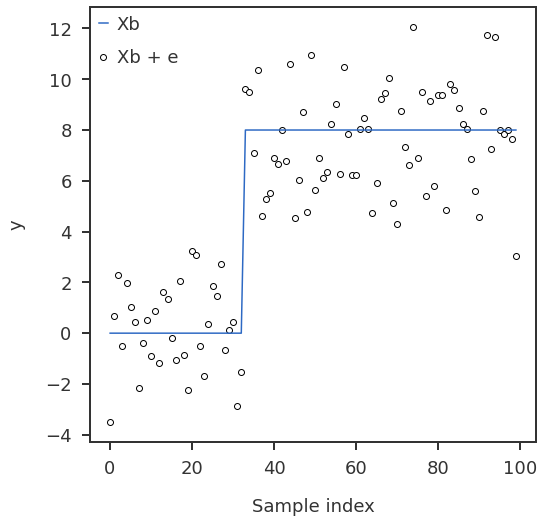

In [3]:
#collapse-show

n = 100
p = 200
bval = 8.0
sd = 2.0
X, y, btrue = trend_data(n, p, bval = bval, sd = sd)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(n), np.dot(X, btrue), label = "Xb")
ax1.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white', label = "Xb + e")
ax1.legend()
ax1.set_xlabel("Sample index")
ax1.set_ylabel("y")
plt.show()

### Initialize all parameters to optimal values

First, I will get an optimal fit, using point estimates of $\mathbf{b}$ and $\mathbf{w}$ (without using the contribution of their variance). And then initialize the second optimization (including the contribution of the variances of $\mathbf{b}$ and $\mathbf{w}$) from the optimal initial values of all parameters.

In [4]:
#collapse-hide

def ridge_mll(X, y, s2, sb2, W):
    n, p = X.shape
    Xscale = np.dot(X, np.diag(W))
    XWWtXt = np.dot(Xscale, Xscale.T)
    sigmay = s2 * (np.eye(n) + sb2 * XWWtXt)
    muy    = np.zeros((n, 1))
    return log_density.mgauss(y.reshape(-1,1), muy, sigmay)

def grr_step(X, y, s2, sb2, muW, varW, XTX, XTy, useVW=True):
    n, p = X.shape
    W = np.diag(muW)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    VW = np.diag(XTX) * np.diag(varW) if useVW else np.zeros(p)
    
    sigmabinv = (WtXtXW + np.diag(VW) + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W.T, XTy]) / s2
    
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    s2 = (np.sum(np.square(y - XWmu)) \
          + np.dot((WtXtXW + np.diag(VW)), sigmab).trace() \
          + np.sum(mub2 * VW)) / n
    sb2 = (np.sum(mub2) + sigmab.trace()) / p
    return s2, sb2, mub, sigmab


def elbo(X, y, s2, sb2, sw2, mub, sigmab, Wbar, varW, XTX, useVW=True):
    '''
    Wbar is a vector which contains the diagonal elements of the diagonal matrix W
    W = diag_matrix(Wbar)
    Wbar = diag(W)
    --
    VW is a vector which contains the diagonal elements of the diagonal matrix V_w
    '''
    n, p = X.shape
    VW = np.diag(XTX) * np.diag(varW) if useVW else np.zeros(p)
    elbo = c_func(n, p, s2, sb2, sw2) \
           + h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW) \
           + h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varW, VW)
    return elbo


def c_func(n, p, s2, sb2, sw2):
    val  =   p
    val += - 0.5 * n * np.log(2.0 * np.pi * s2)
    val += - 0.5 * p * np.log(sb2)
    val += - 0.5 * p * np.log(sw2)
    return val


def h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW):
    XWmu = np.linalg.multi_dot([X, np.diag(Wbar), mub])
    val1 = - (0.5 / s2) * np.sum(np.square(y - XWmu))
    val2 = - 0.5 * np.sum(np.square(mub) * ((VW / s2) + (1 / sb2)))
    val3 = - 0.5 * np.sum(np.square(Wbar)) / sw2
    val  = val1 + val2 + val3
    return val


def h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, sigmaw, VW):
    (sign, logdetS) = np.linalg.slogdet(sigmab)
    (sign, logdetV) = np.linalg.slogdet(sigmaw)
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    val  =   0.5 * logdetS + 0.5 * logdetV
    val += - 0.5 * np.trace(sigmab) / sb2 - 0.5 * np.trace(sigmaw) / sw2
    val += - 0.5 * np.dot(WtXtXW + np.diag(VW), sigmab).trace() / s2
    return val
    

def ebmr_WB2(X, y,
             s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
             binit = None, winit = None,
             sigmab_init = None, sigmaw_init = None,
             use_wb_variance = True,
             ignore_b_update = False,
             ignore_w_update = False,
             ignore_s2_update = False,
             max_iter = 1000, tol = 1e-8
            ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.ones(n_features) if binit is None else binit
    muw = np.ones(n_features) if winit is None else winit
    sigmab = np.zeros((n_features, n_features))  if sigmab_init is None else sigmab_init
    sigmaw = np.zeros((n_features, n_features))  if sigmaw_init is None else sigmaw_init
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    
    for itn in range(1, max_iter + 1):
        '''
        GRR for b
        '''
        if not ignore_b_update:
            if ignore_s2_update:
                #print ("Updating b without s2")
                __, sb2, mub, sigmab = grr_step(X, y, s2, sb2, muw, sigmaw, XTX, XTy, useVW=use_wb_variance)
            else:
                #print ("Updating b")
                s2, sb2, mub, sigmab = grr_step(X, y, s2, sb2, muw, sigmaw, XTX, XTy, useVW=use_wb_variance)
        
        '''
        GRR for W
        '''
        if not ignore_w_update:
            #print ("Updating w")
            __, sw2, muw, sigmaw = grr_step(X, y, s2, sw2, mub, sigmab, XTX, XTy, useVW=use_wb_variance)
            
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, sw2, mub, sigmab, muw, sigmaw, XTX, useVW=use_wb_variance)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muw)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        #if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muw, sigmaw, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

It leads to similar underfitting as we have seen before.

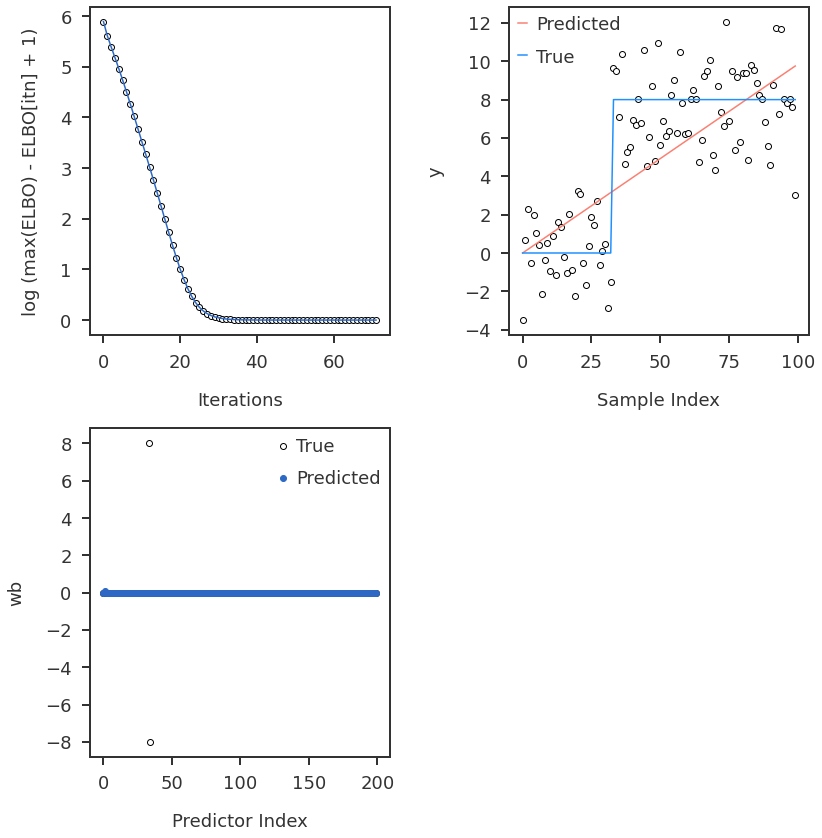

In [5]:
#collapse-hide
m1 = ebmr_WB2(X, y, use_wb_variance=False)
# s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m1

m2 = ebmr_WB2(X, y, use_wb_variance=True, 
              s2_init = m1[0], 
              sb2_init = m1[1], 
              sw2_init = m1[2],
              binit = m1[3],
              sigmab_init = m1[4],
              winit = m1[5],
              sigmaw_init = m1[6]
             )

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m2
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

yvals = np.log(np.max(elbo_path[1:]) - elbo_path[1:] + 1)
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter), yvals)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("log (max(ELBO) - ELBO[itn] + 1)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor Index")
ax3.set_ylabel("wb")

# nstep = min(80, niter - 2)
# ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
# ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
# ax4.legend()
# ax4.set_xlabel("Iterations")
# ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### Fix initial values of $\sigma^2$.

Next, I will use the initial values from the "optimal" fit and fix the value for $\sigma^2$ and allow the updates of all other parameters.

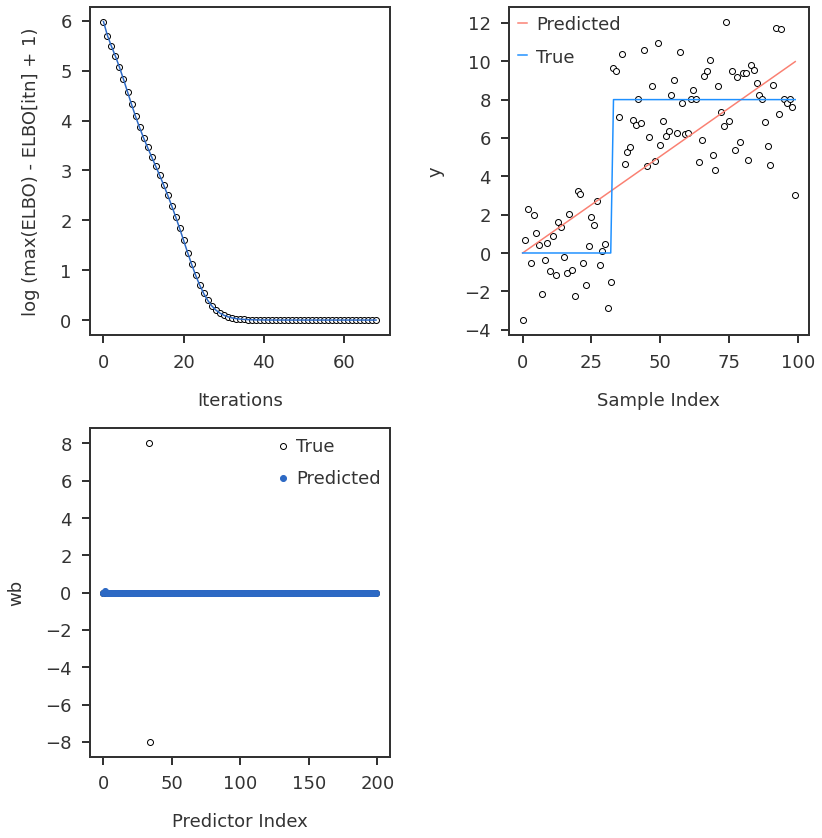

In [6]:
#collapse-hide
m3 = ebmr_WB2(X, y, use_wb_variance=True, 
              s2_init = m1[0], 
              sb2_init = m1[1], 
              sw2_init = m1[2],
              binit = m1[3],
              sigmab_init = m1[4],
              winit = m1[5],
              sigmaw_init = m1[6],
              ignore_s2_update=True,
             )

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m3
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)


yvals = np.log(np.max(elbo_path[1:]) - elbo_path[1:] + 1)
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter), yvals)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("log (max(ELBO) - ELBO[itn] + 1)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor Index")
ax3.set_ylabel("wb")

# nstep = min(80, niter)
# ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
# ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
# ax4.legend()
# ax4.set_xlabel("Iterations")
# ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### Fix initial values of $\sigma^2$, $\sigma_b^2$, $\mathbf{m}$ and $\mathbf{S}$.

Next, I will use the initial values from the "optimal" fit and fix the values for the updates of $\mathbf{b}$.

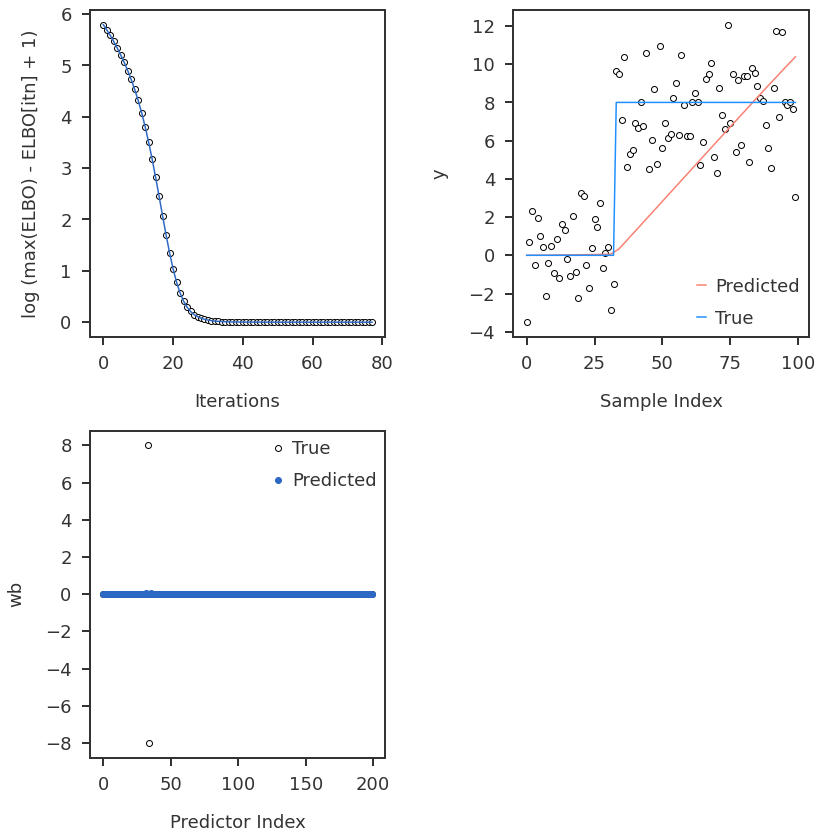

In [7]:
#collapse-hide
m4 = ebmr_WB2(X, y, use_wb_variance=True, 
              s2_init = m1[0], 
              sb2_init = m1[1], 
              sw2_init = m1[2],
              binit = m1[3],
              sigmab_init = m1[4],
              winit = m1[5],
              sigmaw_init = m1[6],
              ignore_b_update=True,
             )

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m4
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)


yvals = np.log(np.max(elbo_path[1:]) - elbo_path[1:] + 1)
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter), yvals)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("log (max(ELBO) - ELBO[itn] + 1)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor Index")
ax3.set_ylabel("wb")

# nstep = min(80, niter)
# ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
# ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
# ax4.legend()
# ax4.set_xlabel("Iterations")
# ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### Fix initial values of $\sigma_w^2$, $\mathbf{a}$ and $\mathbf{V}$.

Next, I will use the initial values from the "optimal" fit and fix the values for the updates of $\mathbf{w}$.

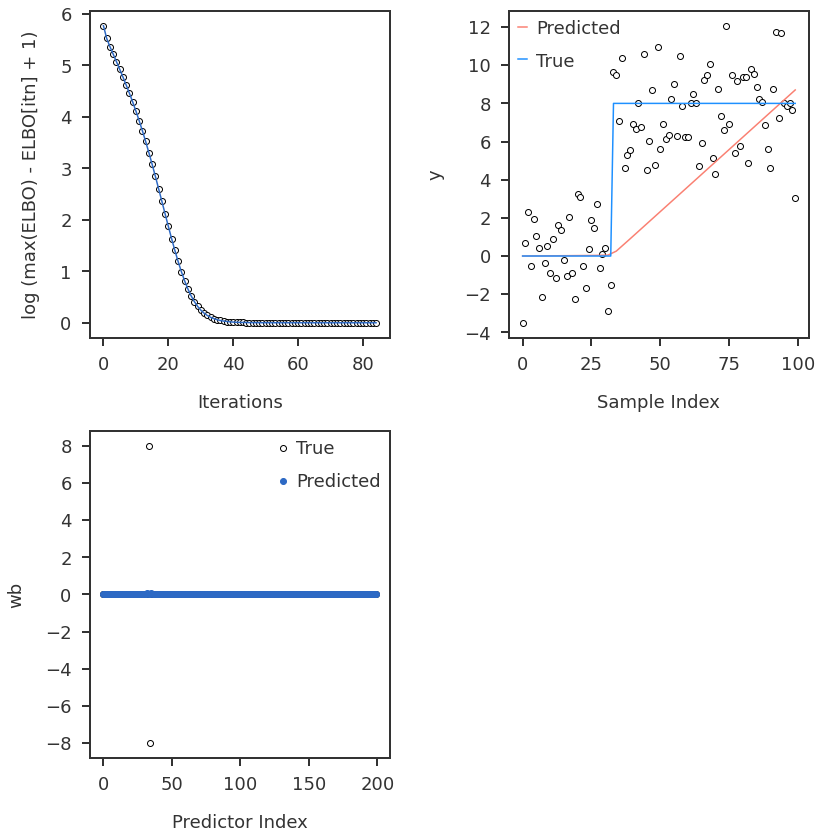

In [8]:
#collapse-hide
m5 = ebmr_WB2(X, y, use_wb_variance=True, 
              s2_init = m1[0], 
              sb2_init = m1[1], 
              sw2_init = m1[2],
              binit = m1[3],
              sigmab_init = m1[4],
              winit = m1[5],
              sigmaw_init = m1[6],
              ignore_w_update=True,
             )

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m5
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)


yvals = np.log(np.max(elbo_path[1:]) - elbo_path[1:] + 1)
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter), yvals)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("log (max(ELBO) - ELBO[itn] + 1)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor Index")
ax3.set_ylabel("wb")

# nstep = min(80, niter)
# ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
# ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
# ax4.legend()
# ax4.set_xlabel("Iterations")
# ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### The "optimum" initialization and fixed $\sigma^2$

I found this unexpectedly, but keeping it here if it helps in debug. 

Essentially, I obtain "optimum" point estimates of $\mathbf{b}$ and $\mathbf{w}$ (without using the contribution of their variance) and fixing $\sigma^2 = 1.0$. I then use this set of values for initializing the EBMR (including the variances of $\mathbf{b}$ and $\mathbf{w}$) and run the optimization, again with the fixed value of $\sigma^2 = 1.0$.

Although this provides a "visually better" prediction than previous attempts, the coefficients are still estimated poorly. This indicates that I am probably making mistake in the update of $\sigma^2$.

In [9]:
#collapse-show
m6 = ebmr_WB2(X, y, use_wb_variance=False, 
              s2_init = 1.0,
              ignore_s2_update=True,
             )

m7 = ebmr_WB2(X, y, use_wb_variance=True, 
              s2_init = 1.0,
              sb2_init = m6[1], 
              sw2_init = m6[2],
              binit = m6[3],
              sigmab_init = m6[4],
              winit = m6[5],
              sigmaw_init = m6[6],
              ignore_s2_update = True
             )

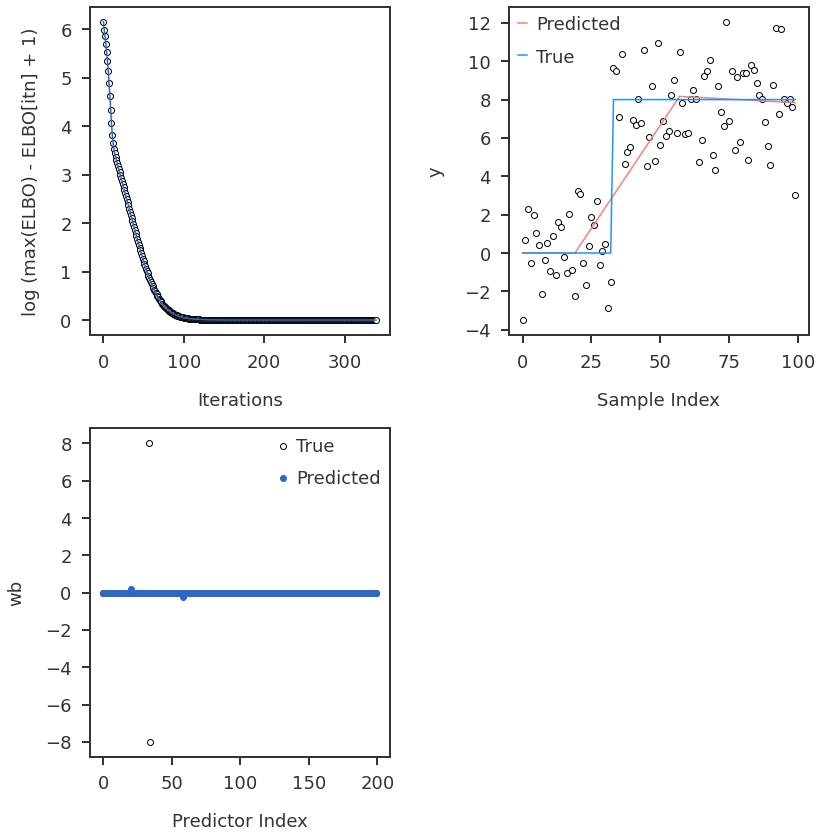

In [10]:
# collapse-hide

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m7
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)


yvals = np.log(np.max(elbo_path[1:]) - elbo_path[1:] + 1)
ax1.scatter(np.arange(niter), yvals, edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter), yvals)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("log (max(ELBO) - ELBO[itn] + 1)")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Predictor Index")
ax3.set_ylabel("wb")

# nstep = min(80, niter)
# ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white', label="Evidence")
# ax4.plot(np.arange(nstep), elbo_path[-nstep:], label="ELBO")
# ax4.legend()
# ax4.set_xlabel("Iterations")
# ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()